In [1]:
# logging utility

import time
from datetime import datetime

LOG_FILE = "latent_experiment_log_180226.txt"

def log_message(message: str):
    stamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    line = f"[{stamp}] {message}"
    with open(LOG_FILE, "a", encoding="utf-8") as f:
        f.write(line + "\n")



In [2]:
# --------------------------------------------------------------
# Latent-Space Face Impersonation (Reduced-Compute Variant)
# MSc Dissertation - Stella Williams
# Inversion-free latent target synthesis experiment
# Single-run evaluation to ensure method works for multirun
# This run is to get the plot working from file 2_latent_impersonation_stylegan-refactor_NO_INVERSION_Loop2. 
# --------------------------------------------------------------




In [3]:
import os
import sys
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1


In [4]:
"Cell 2: Device, FaceNet setup"


# --------------------------------------------------------------
# Device configuration
# --------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# --------------------------------------------------------------
# FaceNet embedding model (verification system)
# --------------------------------------------------------------

facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)
# --------------------------------------------------------------
# Preprocessing for FaceNet (160x160 input requirement)
# --------------------------------------------------------------
to_facenet = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

def load_image(path):
    return Image.open(path).convert("RGB")

def img_to_tensor(img):
    return to_facenet(img).unsqueeze(0).to(device)

@torch.no_grad()
def facenet_embed(img_tensor):
    emb = facenet(img_tensor)
    return nn.functional.normalize(emb, p=2, dim=1)

def cosine(a, b):
    return (a * b).sum(dim=1)



Using device: cpu


In [5]:
# --------------------------------------------------------------
# Load pretrained StyleGAN2-ADA generator
# --------------------------------------------------------------
import sys
sys.path.append("/Users/stel/Documents/Dissertation/msc-biometric-security-clean/stylegan2-ada-pytorch")



import pickle

STYLEGAN_REPO = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/stylegan2-ada-pytorch"
STYLEGAN_PKL  = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Models/stylegan2-ffhq.pkl"

if STYLEGAN_REPO not in sys.path:
    sys.path.append(STYLEGAN_REPO)

with open(STYLEGAN_PKL, "rb") as f:
    G = pickle.load(f)["G_ema"].to(device).eval()

print("Loaded StyleGAN2")
print("z_dim:", G.z_dim)





Loaded StyleGAN2
z_dim: 512


In [6]:
# --------------------------------------------------------------
# Generator wrapper
# Converts single w latent into w+ internally
# --------------------------------------------------------------

def synth_from_w_single(w):
    """
    Accepts either:
    - w shape [1, w_dim]
    - w shape [1, num_ws, w_dim] (w+)

    Returns image in [0,1]
    """

    if w.ndim == 2:
        # w is [1, w_dim] → broadcast to w+
        w_plus = w.unsqueeze(1).repeat(1, G.synthesis.num_ws, 1)
    elif w.ndim == 3:
        # Already w+
        w_plus = w
    else:
        raise ValueError(f"Unexpected latent shape: {w.shape}")

    img = G.synthesis(w_plus, noise_mode="const")
    img = (img + 1) / 2
    return img.clamp(0, 1)



In [7]:
# --------------------------------------------------------------
# Load target identity (impersonation objective)
# --------------------------------------------------------------

TARGET_A_PATH = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Datasets/lfw/Lenny_Kravitz/Lenny_Kravitz_0001.jpg"
TARGET_B_PATH = "/Users/stel/Documents/Dissertation/msc-biometric-security-clean/Datasets/lfw/Patricia_Clarkson/Patricia_Clarkson_0001.jpg"

targetA_img = load_image(TARGET_A_PATH)
targetB_img = load_image(TARGET_B_PATH)

targetA_t = img_to_tensor(targetA_img)
targetB_t = img_to_tensor(targetB_img)

with torch.no_grad():
    e_target = facenet_embed(targetA_t)
    e_nontarget = facenet_embed(targetB_t)

print("Target embedding norm:", e_target.norm().item())

# print("Initial w shape:", w.shape)
#inspecting the shape, it is likely [1, 1, w_dim], or [1, num_ws, w_dim] - with the latter meaning
#we are alreadz in w+ space and the wrapper must not broadcast again. in my previous version, no loop,
#i initialised w differently, mapping for from a random latent or mapping. dimensions changed.
print("Target embedding ready.")

Target embedding norm: 1.0
Target embedding ready.


In [8]:
log_message("--------------------------------------------------")
log_message(f"Experiment started: {datetime.now()}")
log_message("Reduced-compute latent impersonation batch")
log_message("--------------------------------------------------")

In [9]:
MAX_STEPS = 3
LR = 0.03

log_message("--------------------------------------------------")
log_message("Single-run 3-step latent impersonation test")
log_message("--------------------------------------------------")

# Random z initialisation
z = torch.randn(1, G.z_dim, device=device)
with torch.no_grad():
    w = G.mapping(z, None)

w = w.clone().detach().requires_grad_(True)
optimizer = optim.Adam([w], lr=LR)

start_time = time.time()

pbar = tqdm(range(MAX_STEPS), desc="Single Run", leave=True)

for step in pbar:
    img = synth_from_w_single(w)
    img_160 = nn.functional.interpolate(img, (160,160), mode="bilinear", align_corners=False)

    emb = facenet(img_160)
    emb = nn.functional.normalize(emb, dim=1)

    sim_target = cosine(emb, e_target)
    sim_nontarget = cosine(emb, e_nontarget)

    loss = 1 - sim_target.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_postfix({
        "cos_target": f"{sim_target.item():.4f}",
        "cos_non_target": f"{sim_nontarget.item():.4f}"
    })

    log_message(
        f"Step {step} | "
        f"cos_target={sim_target.item():.4f} | "
        f"cos_non_target={sim_nontarget.item():.4f}"
    )

runtime = time.time() - start_time

final_target = sim_target.item()
final_non_target = sim_nontarget.item()

print("\nFinal Results")
print("Cosine (Target A):", final_target)
print("Cosine (Non-Target B):", final_non_target)
print("Runtime (minutes):", runtime/60)

log_message(
    f"FINAL | cos_target={final_target:.4f} | "
    f"cos_non_target={final_non_target:.4f} | "
    f"runtime_min={runtime/60:.2f}"
)


Single Run: 100%|█| 3/3 [18:17<00:00, 365.78s/it, cos_target=0.5797, cos_non_tar


Final Results
Cosine (Target A): 0.5796542763710022
Cosine (Non-Target B): -0.10197757184505463
Runtime (minutes): 18.289206794897716


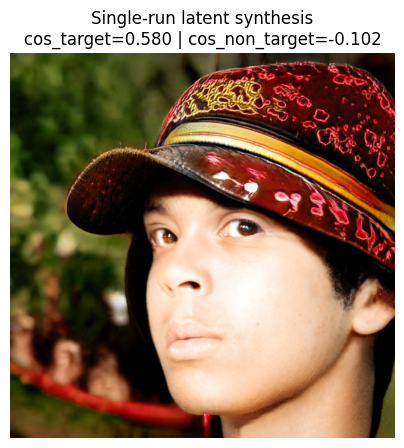

In [10]:
with torch.no_grad():
    final_img = synth_from_w_single(w).detach().cpu()

plt.figure(figsize=(5,5))
plt.imshow(final_img.squeeze().permute(1,2,0))
plt.title(
    f"Single-run latent synthesis\n"
    f"cos_target={final_target:.3f} | cos_non_target={final_non_target:.3f}"
)
plt.axis("off")
plt.show()
